# Herramienta de estimaciones de distancia y módulo de distancia

En este tutorial estudiaremos el uso de herramientas para la estimación de la distancia a partir de la paralaje. La fórmula habitual $r = 1/\varpi$ tiene muchas limitaciones y sesgos, y aquí presentaremos otras alternativas más robustas.

Este tutorial es una adaptación de las herramientas del artículo
[Using Gaia parallaxes, Luri et al. (2018)](https://www.aanda.org/articles/aa/full_html/2018/08/aa32964-18/aa32964-18.html) que pueden encontrarse [github](https://github.com/agabrown/astrometry-inference-tutorials)

Las secciones 1-4 son introductorias y presentan los conceptos básicos de los estimadores y el uso de las herramientas. Puede también leerse el documento PDF adjunto a este tutorial [DR2_distance_estimators_performance](./DR2_distance_estimators_performance.pdf). En la sección 5 se propone un ejercicio para practicar el uso de estos estimadores.

<hr>

1. Introduction
2. Using the interface DistanceEstimatorApplication.py
3. Using the module _pyrallaxes.py_
4. Define new priors using _pyrallaxes.py_
5. __Exercise__
5. Conclusions
6. References

## 1. Introduction

This tutorial is intended to explain how to use the module _pyrallaxes.py_, which is a part of the series of Tutorials on the use of Gaia parallaxes, and has been developed by the Gaia team as a support of the article by [Luri et al. (2018)](https://arxiv.org/abs/1804.09376).

The main idea that we want to highlight with this tutorial is that __there are better methods rather than inverting the parallax for computing both distances and distance modulus, and that these methods are not much effort consuming__. We also want to offer you some useful tools so you can do it easily.

The module _pyrallaxes.py_ provides tools and functions for computing **distances and distance modulus** from trigonometric parallaxes and their associated errors using both **Bayesian and frequentist methods**. The theoretical basis in which the developed functions are grounded can be found in _Estimating Distances from Parallaxes_ by Coryn A. L. Bailer-Jones (http://iopscience.iop.org/article/10.1086/683116/pdf) for the Bayesian methods and in _Transformation methods for Trigonometric Parallaxes_ by Haywood Smith, Jr. (http://www.astro.ufl.edu/~asthcs/BadH2.pdf). 

In order to use the module you will need Python3. You can import it as follows

In [4]:
from pyrallaxes import *

You will also need to execute this cell in order to import _matplotlib.pyplot_ and _numpy_, since we will use it for plotting the results.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

### 1.1. Why not inverting the parallax?

Although the parallax is the measured quantity, the user is usually interested in derived quantities such as the distance and the modulus distance. Despite there exists a direct relationship between the parallax and the distance, inverting the parallax is only correct when there is no measurement error. Due to this error we can even measure negative parallaxes, which correspond to far away objects with a large measurement error. The usual way of handling negative parallaxes consist in discarding them, although this practice biases the sample. A proper statistical treatment of the parallaxes of the sample in hand is the only correct way to proceed. 

This statistical treatment is usually time expensive for the user, who usually skips the task and directly inverts the parallax, biasing the sample. 

We offer two Bayesian Methods and a frequentist method that perform better than just inverting the parallax. 

### 1.2. Bayesian Methods and the Transformation Methods

Bayesian Methods allow to infer the distance of an object through a model error or likelihood
$$P(\varpi|r,\sigma) = \frac{1}{\sqrt{2\pi} \sigma} \exp\left(-\frac{1}{2\sigma^2}\left(\varpi-\frac{1}{r}\right)^2\right)$$
and _a priori_ assumption, the prior. We have developed the module _pyrallaxes.py_ in order to use the _Uniform Density Prior_ and the _Exponentially Decreasing Space Density Prior_ suggested by Coryn in [1] in order to compute both distance and distance modulus ($\mu = 5\log_{10} r - 5 = 5\log_{10} \varpi - 5$). **Other priors can also be used, the funtions of the module are general.** We explain how to define new priors in section 4.

The Transformation Method is a frequentist method described by Haywood Smith [2], which tries to find a transformation of the observed parallax that, once inverted, approaches better the true distance and corrects the problematic issues of the definition $r = \frac{1}{\varpi}$, i.e., the divergence of the distance for small $\varpi$ (the observed parallax) and the existence of negative distances. We have used the estimates $r^*$  and $\mu^*$ described in "Transformation methods for trigonometric parallaxes" by Haywood Smith [3]
$$r^* = \frac{1}{\varpi^*}$$
where $$\varpi^* = \beta \sigma \phi g_\phi $$
and $\phi = \frac{1}{0.8} \ln (1+e^{\frac{0.8\varpi}{\sigma}})$ and $g_{\phi} = 1$ if $\varpi > 0$ and $g_{\phi} = e^{-0.605\frac{\varpi^2}{\sigma^2}}$ for $\varpi \leq 0$, with $\beta = 1.01$; as well as the absolute magnitude distance estimate $\hat{M}$ described at [2]
$$\hat{M} = m + 5\log_{10}\hat{\varpi} +5$$
with $m$ the observed magnitude and $\hat{\varpi}$ defined as
$$\hat{\varpi} = \beta \sigma \left(\frac{1}{e^\phi + e^{\frac{-5\varpi}{\sigma}}}+ e^\phi\right)$$
with $\phi = \frac{1}{0.8} \ln (1+e^{\frac{0.8\varpi}{\sigma}})$ and $\beta = 1.01$.
Therefore, the distance modulus can be defined as
$$\mu^* = m - \hat{M} = -(5\log(\hat{\varpi}) + 5)$$


 ## 2. Using the interface _DistanceEstimatorApplication.py_

Fisrst of all we are going to explain how to use the interface  _DistanceEstimatorApplication.py_, so if you are just interested in the methods described above, you can compute the distances and distance modulus automatically. It also allow you to save the plots of the probability distribution functions (PDF) of the Bayesian Methods. In the following we will explain how to use in detail the module _pyrallaxes_ and how to define new priors.

**Note: in order to use the interface you need a command-line python terminal. If you are using this tutorial from a purely notebook environment you can just read this section and execute from section 3 onwards.**

You will see the _Input Data_ window.
![Snapshot of the DistanceEstimatorApplication](image1.png)

All the checkbuttons are selected by default. Select the methods you wish to use to compute distance and distance modulus. It is mandatory that you fill in the fields of parallax and parallax error, both in milliarcseconds (mas). Click the button 'Confirm the selected options'.

This will lead you to a second window where the results of the computation are shown. You can also view the probability distribution functions (PDF) with the mode, the median and the 90% uncertainty interval shown for the Bayesian Methods. 


Let's try three representative examples:

### 2.1. Good parallax

A good parallax is a positive parallax with small fractional parallax error $f =\frac{\sigma}{\varpi}$ (inferior to the 20%). For instance, try the next values in the _DistanceEstimatorApplication.py_.

In [3]:
parallax = 1.234 #mas
parallax_error = 0.15 #mas
observed_distance_modulus = 20
f = parallax_error/parallax*100
print('Approximate relative parallax error: ',round(f),'%')

Approximate relative parallax error:  12 %


You will obtain

![Snapshot of the DistanceEstimatorApplication](image2.png)

With the PDF's for the Uniform Distance PDF 
![Snapshot of the DistanceEstimatorApplication](image3.png)
for the Exponentially Decreasing Space Density PDF
![Snapshot of the DistanceEstimatorApplication](image4.png)
for the Uniform Distance PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image5.png)
and for the Exponentially Decreasing Space Density PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image6.png)

**As you can see, all the computed distances by the three methods are alike, coinciding within the uncertainty interval.** Since the parallax is good, the result of inverting the parallax will be similar to the computed ones, as we can check.

In [4]:
# Result of inverting the parallax
print('Result of inverting the parallax: ',1/parallax*1000,' +-',parallax_error/parallax**2*1000,' pc')

Result of inverting the parallax:  810.3727714748784  +- 98.50560431218133  pc


where we have computed the uncertainty associated to the distance as the Taylor expansion to first order. We can also compute the distance modulus using directly the observed parallax.

In [5]:
print('Distance modulus inverting the parallax: ',-5*np.log10(parallax/1000)-5,'+-',5*parallax_error/parallax)

Distance modulus inverting the parallax:  9.543424201513886 +- 0.6077795786061588


### 2.2. Bad parallax

We consider a 'bad parallax' a parallax with a large fractional parallax error (superior to the 20%). Let's observe what happens with the distances for the below values executing _DistanceEstimatorApplication.py_

In [7]:
parallax = 1.234 #mas
parallax_error = 0.65 #mas
observed_distance_modulus = 20
f = parallax_error/parallax*100
print('Approximate relative parallax error: ',round(f),'%')

Approximate relative parallax error:  53 %


With these values you will obtain

![Snapshot of the DistanceEstimatorApplication](image7.png)

With the PDF's for the Uniform Distance PDF 
![Snapshot of the DistanceEstimatorApplication](image8.png)
for the Exponentially Decreasing Space Density PDF
![Snapshot of the DistanceEstimatorApplication](image9.png)
for the Uniform Distance PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image10.png)
and for the Exponentially Decreasing Space Density PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image11.png)

**As you can appreciate the results obtained by the different estimates differ sharply of the others.** However, the results obtained using the different methods are compatible within the uncertainty ranges. We can also compare with the distance and the distance modulus  

In [8]:
# Result of inverting the parallax
print('Result of inverting the parallax: ',1/parallax*1000,' +-',parallax_error/parallax**2*1000,' pc')


Result of inverting the parallax:  810.3727714748784  +- 426.85761868611917  pc


where we have computed the uncertainty associated to the distance as the Taylor expansion to first order. We can also compute the distance modulus using directly the observed parallax.

In [9]:
print('Distance modulus inverting the parallax: ',-5*np.log10(parallax/1000)-5,'+-',5*parallax_error/parallax)

Distance modulus inverting the parallax:  9.543424201513886 +- 2.633711507293355


### 2.3. Negative parallax

A negative parallax is also a physically possible observable, corresponding to far away objects with large parallax error. If we just invert the parallax, we obtain a negative distance, which has not physical sense. Let's try with the values

In [10]:
parallax = - 0.95 #mas
parallax_error = 0.65 #mas
observed_distance_modulus = 20
f = abs(parallax_error/parallax*100)
print('Approximate relative parallax error: ',round(f),'%')

Approximate relative parallax error:  68 %


With these values you will obtain

![Snapshot of the DistanceEstimatorApplication](image12.png)

With the PDF's for the Uniform Distance PDF 
![Snapshot of the DistanceEstimatorApplication](image13.png)
for the Exponentially Decreasing Space Density PDF
![Snapshot of the DistanceEstimatorApplication](image14.png)
for the Uniform Distance PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image15.png)
and for the Exponentially Decreasing Space Density PDF for the distance modulus
![Snapshot of the DistanceEstimatorApplication](image16.png)

**As you can appreciate the results obtained by the different estimates differ sharply of the others.** The Uniform Space Prior brings the mode to the limit and the 95% uncertainty interval increases, indicating that the possibility of having the star far away is much more likely than before. The Exponentially Decreasing Space Density Posterior is kept finite and its 95% percentile small in comparison with the results obtained using the Uniform Density Prior. In fact, in the worst cases the Exponentially Decreasing Space Density PDF substimates the true distance while the Uniform Space PDF overestimates it.

## 3. Using _pyrallaxes.py_

In this section I will go over the different functions of the module _pyrallaxes.py_ and I will show how to create a program for computing the different estimates.

### 3.1. Computing distances

Let's start defining the parameters w--> parallax and s--> parallax error and compute all three distance  estimates through the two Bayesian Methods and the Transformation Method. In the first cell you have two values of parallax (w) and parallax error (s) in mas. You can change them as you wish and observe the resulting PDF (remember to execute the cell after changing the values). Due to the numerical limits used in the integration routines you should not use a parallax larger than 100 mas. Be careful with the units!!! 

In [32]:
w = 1.434 # mas PARALLAX
s = 0.84 #mas PARALLAX ERROR

You will need two more parameters characteristics of the priors used, $r_{lim}$ and $L$, which are the cut off of the Uniform Distance Prior and the length scale of the Exponentially Decreasing Space Density Prior. Moreover, we will also need a starting point in the integration $r_0$ and a numerical value of the Transformation Method, beta = 1.01. **You should not change them, since all the tests realized to these estimators have been done with the following parameters, as they are the ones that have provided the best results**. If you change the numerical values of these parameters we cannot grant that they work better than inverting the parallax. In order to do so, you should first test them with a simuated sample $^{[1]}$.

We are also going to define the inferior and superior normalized percentiles that we wish to compute. For instance, since we are looking after a 90% uncertainty interval we are going to define p_inf = 0.05 and p_sup = 0.95. You can change these values if you wish to increase or decrease the uncertainty interval. 

-------------------------------------------------------------------------------------------------------------------------------
$^{[1]}$ If you want to carry out a test you should generate a file with true parallaxes, their associated parallax error and a noisy simulated parallaxes extracted from the model error (likelihood). You should then compute the distance and the distance modulus using the these priors with the new numerical values of the parameters and compare them with the true simulated distance and distance modulus. 



In [33]:
L = 1.35 #kpc
r_lim = 100 #kpc
r0 = 0.01 #kpc
beta = 1.01

p_inf = 0.05 # Normalized inferior percentile
p_sup = 0.95 # Normalized superior percentile

First of all we are going to compute the mode of the two Bayesian estimates, since we can calculate it just using w and s. After that, we will compute the percentile corresponding to the mode, so we can use the mode and its percentile as a starting point for computing the median and the 90% uncertainty interval. Before that, however, we will need to compute the normalization factor and to normalize the percentiles.

#### Uniform Distance Prior

In [34]:
r_mode_ud = mode_r_uniform(w, r_lim) 
    
p_ud = percentiles(uniform_distance_posterior, r0, r_mode_ud, w, s,r_lim)  # Computing the percentile that corresponds to the mode of the PDF
n_ud = normalization(uniform_distance_posterior, r_lim, w, s, p_ud, r_mode_ud,r_lim)  # Computing the normalization constant of the PDF
p_ud = normalized_percentile(p_ud, n_ud)  # Normalized percentile. The percentile now ranges from 0 to 1.
    
# Secondly, we can compute the median of the PDF, using as a reference the mode and its associated percentile (this allows to speed up the calculations)         
r_media_ud = median(uniform_distance_posterior,w,s,r_lim,r_lim,r_mode_ud,p_ud,n_ud)
     
# Finally, we compute the distances corresponding to the superior and inferior bound percentiles. We use the median of the PDF as a reference, since it divides the PDF into two halves
r_ud_sup = distances_from_percentiles(uniform_distance_posterior, n_ud, w, s, 'sup', p_inf, p_sup,0.5, r_media_ud, r_lim, r_lim)
r_ud_inf = distances_from_percentiles(uniform_distance_posterior,n_ud,w,s,'inf',p_inf,p_sup,0.5,r_media_ud,r_lim,r_lim)
    

#### Exponentially Decreasing Space Density Prior

In [35]:
# We first compute the mode of the PDF
r_mode_exp = mode_r_exponential(L, w, s)
                    
p_exp = percentiles(exponentially_decreasing_space_density_posterior,r0,r_mode_exp,w,s,L)# Computing the percentile that corresponds to the mode of the PDF
n_exp = normalization(exponentially_decreasing_space_density_posterior,L,w,s,p_exp,r_mode_exp,r_lim)# Computing the normalization constant of the PDF
p_exp = normalized_percentile(p_exp,n_exp) # Normalized percentile. The percentile now ranges from 0 to 1.
    
# Secondly, we can compute the median of the PDF, using as a reference the mode and its associated percentile (this allows to speed up the calculations)         
r_media_exp = median(exponentially_decreasing_space_density_posterior,w,s,L,r_lim,r_mode_exp,p_exp,n_exp)
    
# Finally, we compute the distances corresponding to the superior and inferior bound percentiles. We use the median of the PDF as a reference, since it divides the PDF into two halves
r_exp_inf = distances_from_percentiles(exponentially_decreasing_space_density_posterior, n_exp, w, s, 'inf', p_inf, p_sup,0.5, r_media_exp, L, r_lim)
r_exp_sup = distances_from_percentiles(exponentially_decreasing_space_density_posterior, n_exp, w, s, 'sup', p_inf, p_sup,0.5, r_media_exp, L, r_lim)


#### Transformation Method for distances

This is a frequentist method, so we will not compute the mode nor the median. We are going to provide the estimate $r^*$. The functions developed for the Transformation Method take the parallax and the parallax error in arcseconds, so we first change the units (you don't need to pay attention to this change of units, it is done in the two first lines of code in the cell below).  In order to define a 95.4% uncertainty interval about the estimate $r^*$ we will compute $[r^*(\varpi-2\sigma),r^*(\varpi+2\sigma)]$. You can change the variable _err_ in order to define other uncertainty intervals, for instance _err = s_ for defining a 68.27% uncertainty interval.


In [36]:
wtm = w*10**(-3) # Parallax in arcseconds
stm = s*10**(-3) # Parallax error in arcseconds

err = 2*stm 

# Computing the estimate
rs = rstar(beta, stm, wtm)

# Computing the uncertainty interval
rsmin,rsmax = uncertainty_range_tm(wtm,stm,beta,err)

In the next cell we just develop a code that allows to show the numerical results and to plot the PDF's. 

---------------------------------------------------------------------------
                             Bayesian methods                              
---------------------------------------------------------------------------
	| Mode (pc) 	 Median (pc) 	 r_inf (pc) 	r_sup (pc)
---------------------------------------------------------------------------
UD PDF 	| 697.35 	 45657.74 	 2122.66 	 94520.15
EXP PDF	| 1758.51 	 2944.43 	 855.01 	 7714.52
---------------------------------------------------------------------------


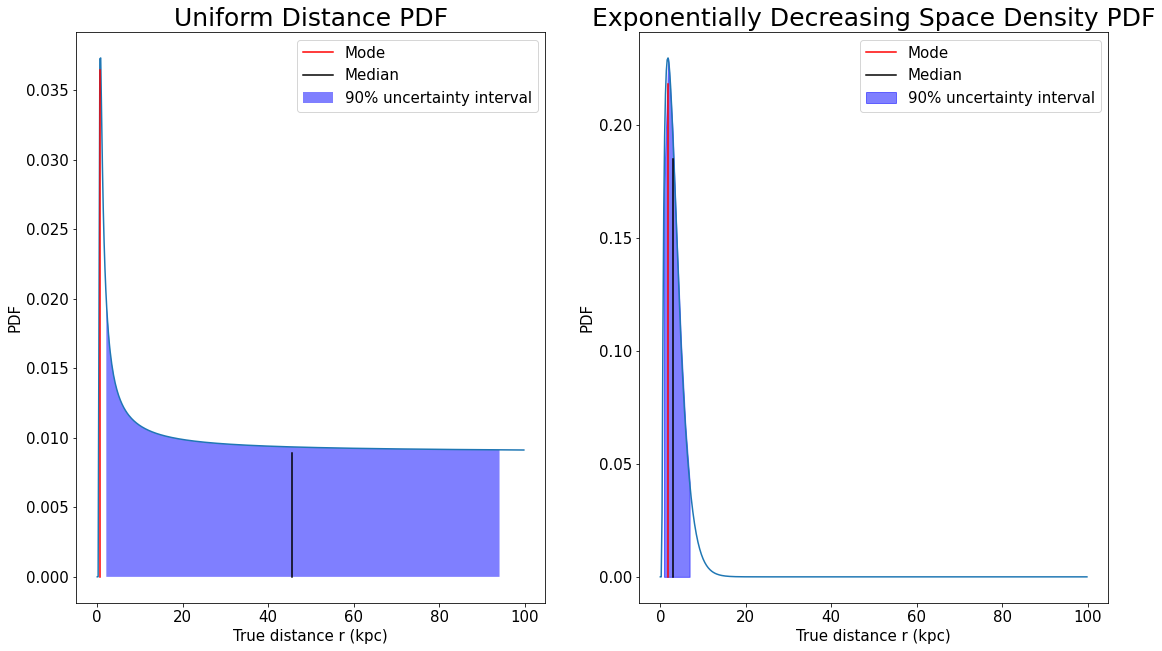





---------------------------------------------------------------------------
                             Transformation Method                         
---------------------------------------------------------------------------
	 r* (pc) 	 Inferior bound (pc)	 Superior bound (pc)
---------------------------------------------------------------------------
	 591.93 	 312.65 	 	 1617.83
---------------------------------------------------------------------------


In [37]:
"""Showing the results"""
    
#Numerical results
print("---------------------------------------------------------------------------")
print("                             Bayesian methods                              ")
print("---------------------------------------------------------------------------")
print("\t| Mode (pc) \t Median (pc) \t r_inf (pc) \tr_sup (pc)")
print("---------------------------------------------------------------------------")
print("UD PDF \t|","{0:.2f}".format(r_mode_ud*1000),"\t","{0:.2f}".format(r_media_ud*1000),"\t","{0:.2f}".format(r_ud_inf*1000),"\t","{0:.2f}".format(r_ud_sup*1000))
print("EXP PDF\t|","{0:.2f}".format(r_mode_exp*1000),"\t","{0:.2f}".format(r_media_exp*1000),"\t","{0:.2f}".format(r_exp_inf*1000),"\t","{0:.2f}".format(r_exp_sup*1000))
print("---------------------------------------------------------------------------")


plot_pdf(r0,r_lim,n_ud,n_exp,r_mode_ud,r_media_ud,r_ud_inf,r_ud_sup,r_mode_exp,r_media_exp,r_exp_inf,r_exp_sup,w,s,r_lim,L,uniform_distance_posterior,exponentially_decreasing_space_density_posterior)


print("\n")
print("\n")
print("---------------------------------------------------------------------------")
print("                             Transformation Method                         ")
print("---------------------------------------------------------------------------")
print("\t r* (pc) \t Inferior bound (pc)\t Superior bound (pc)")
print("---------------------------------------------------------------------------")
print("\t","{0:.2f}".format(rs),"\t","{0:.2f}".format(rsmin),"\t \t","{0:.2f}".format(rsmax))
print("---------------------------------------------------------------------------")

Let's repeat the same procedure for the modulus distance functions. In this case we are going to work in parcecs and arcseconds instead of in milliarcseconds and kiloparsecs, since parsecs are the natural units in which the distance modulus is defined. The computations will be done with the same values of parallax and parallax error that you provided for distances, so you don't need to pay attentio  to this change of units, it is done in the cell bellow.

In [18]:
w = w/1000 # parallax in arcseconds
s = s/1000 # parallax error in arcseconds
r0 = r0*1000 # r0 in parsecs

mu = 10 #Observed distance modulus

mu0 = -10 # starting point of the integration in distance modulus space
r_lim = r_lim *1000 # r_lim in parsecs (pc)
L = L*1000 # length scale in parsecs (pc)
mu_lim = 5*np.log10(r_lim)-5 # distance modulus corresponding to r_lim

#### Uniform Distance Prior for distance modulus

In [19]:
# We first compute the mode of the PDF
m_mode_ud = dmod_mode_ud(w,s,r_lim,dmpdfun)
    
p_ud = percentiles(dmpdfun,mu0,m_mode_ud,w,s,r_lim)
n_mud = normalization(dmpdfun, r_lim, w, s, p_ud, m_mode_ud, mu_lim)
p_ud = normalized_percentile(p_ud, n_mud)
    
m_media_ud = dmod_median(dmpdfun, w, s, r_lim,mu_lim, m_mode_ud, p_ud, n_mud,mu0)   
m_ud_sup = distances_from_percentiles_dmod(dmpdfun, n_mud, w, s, 'sup', p_inf, p_sup, 0.5, m_media_ud, r_lim,mu_lim,mu0)
m_ud_inf = distances_from_percentiles_dmod(dmpdfun, n_mud, w, s, 'inf', p_inf, p_sup, 0.5, m_media_ud, r_lim,mu_lim,mu0)
        

#### Exponentially Decreasing Space Density Prior for distance modulus

In [20]:
m = dmod_mode_exp(w,s,L)

p_exp = percentiles(dmpdfexp,m - 10,m, w, s, L)
n_exp = normalization(dmpdfexp, L, w, s, p_exp, m, m + 10)
p_exp = normalized_percentile(p_exp, n_exp)
        
m_media_exp = dmod_median(dmpdfexp, w, s, L, m + 10, m, p_exp, n_exp,mu0) 

m_exp_inf = distances_from_percentiles_dmod(dmpdfexp, n_exp, w, s, 'inf', p_inf, p_sup, 0.5, m_media_exp, L,m + 10,mu0)
m_exp_sup = distances_from_percentiles_dmod(dmpdfexp, n_exp, w, s, 'sup', p_inf, p_sup, 0.5, m_media_exp, L,m + 10,mu0)
    

#### Transormation Method for distance modulus

In [21]:
err = 2*s 
    
# Computing the estimate
mtm = transformed_parallax(w,s,beta)
# Computing the uncertainty interval
mtm_min,mtm_max = uncertainty_range_mdtm(w,s,beta,err)
    

Showing the results

---------------------------------------------------------------------------
                             Bayesian methods                              
---------------------------------------------------------------------------
	| Mode  	        Median  	 m_inf  	 m_sup 
---------------------------------------------------------------------------
UD PDF 	| 20.00 		 18.30 		 11.63 		 19.88
EXP PDF	| 12.66 		 12.35 		 9.66 		 14.44
---------------------------------------------------------------------------


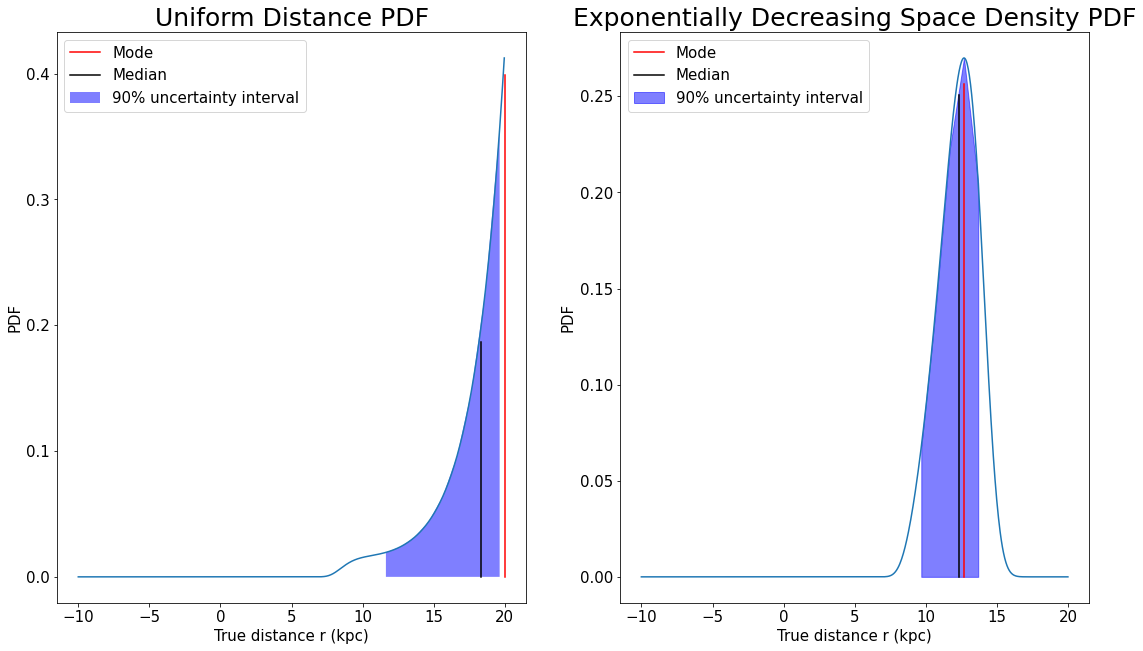





---------------------------------------------------------------------------
                             Transformation Method                         
---------------------------------------------------------------------------
	 m* 	 Inferior bound 	 Superior bound 
---------------------------------------------------------------------------
	 27.18 	 23.78 			 37.75
---------------------------------------------------------------------------


In [22]:
#Numerical results
print("---------------------------------------------------------------------------")
print("                             Bayesian methods                              ")
print("---------------------------------------------------------------------------")
print("\t| Mode  \t        Median  \t m_inf  \t m_sup ")
print("---------------------------------------------------------------------------")
print("UD PDF \t|","{0:.2f}".format(m_mode_ud),"\t\t","{0:.2f}".format(m_media_ud),"\t\t","{0:.2f}".format(m_ud_inf),"\t\t","{0:.2f}".format(m_ud_sup))
print("EXP PDF\t|","{0:.2f}".format(m),"\t\t","{0:.2f}".format(m_media_exp),"\t\t","{0:.2f}".format(m_exp_inf),"\t\t","{0:.2f}".format(m_exp_sup))
print("---------------------------------------------------------------------------")

x = np.arange(mu0,mu_lim,mu_lim/500)
y1 = [dmpdfun(i,w,s,r_lim)/n_mud for i in x]

plot_pdf(mu0,mu_lim,n_mud,n_exp,m_mode_ud,m_media_ud,m_ud_inf,m_ud_sup,m,m_media_exp,m_exp_inf,m_exp_sup,w,s,r_lim,L,dmpdfun,dmpdfexp)

    
print("\n")
print("\n")
print("---------------------------------------------------------------------------")
print("                             Transformation Method                         ")
print("---------------------------------------------------------------------------")
print("\t m* \t Inferior bound \t Superior bound ")
print("---------------------------------------------------------------------------")
print("\t","{0:.2f}".format(mtm),"\t","{0:.2f}".format(mtm_min),"\t\t\t","{0:.2f}".format(mtm_max))
print("---------------------------------------------------------------------------")
    
    

You can now compute the distance and distance modulus for good, bad and negative parallaxes changing the values of w and s given in the cell above the two main programs defined. You can try, for instance,

**Good parallax:**
w = 1.234 (mas);
s = 0.15 (mas)

**Bad parallax:**
w = 1.234 (mas);
s = 0.65 (mas)

**Negative parallax**
w = -0.95 (mas);
s = 0.65 (mas)

## 4. Define new priors using _pyrallaxes.py_

In this section we are going to explore how to create new priors and how to use them in accordance with _pyrallaxes.py_ in order to compute the mode, the median and the uncertainty ranges of other estimates.

First of all, it is important to notice that the choice of prior will influence the obtained results, especially for bad parallaxes. As we have observed, in the case of good parallaxes the choice of prior becomes less important and all of the computed distances and distance modulus coincide. An uninformative prior, as the ones used in the _pyrallaxes.py_ module provides reasonable results, as it is shown in [1]. A more informative prior, i.e., a more complex prior with more ellaborated hypotesis on the star distribution, would provide better results for the samples in accordance to our assumptions. However, the mismatch of the estimated distance and distance modulus would also be larger when the hypotesis are wrong. 

Secondly, we will define unnormalized priors, but it is important that the prior converges in all the domain. If not, we will need a cut off, like the one used in the Uniform Density Prior.

In order to define a new prior we start defining a function, for instance,


In [23]:
def new_prior(x,r_lim):
    if x > 0 and x <= r_lim:
        return 3*x**2/r_lim**3
    else:
        return 0
        

This prior was defined by Coryn in [1] and called the Constant Volume Density Prior. We have not included it in _pyrallaxes_, since the distances computed using this prior give a larger mismatch with the real simulated distances than the other two Bayesian Methods. In order to define the posterior we will also need the likelihood.


In [24]:
def posterior(x,w,s,r_lim):
    return new_prior(x,r_lim)*likelihood(x,w,s)

We must now compute the mode of the posterior. The mode of the posterior is the estimate distance and distance modulus with the highest probability of occurrance, i.e., it is the result of solving $\frac{d P}{dx} = 0$. We can thus calculate it in different ways, both analytic and numerical. 

One numerical way would be finding the maximum of the PDF in the domain of the distribution. We can do this sampling the PDF and choosing its maximum value. We can also use the _numpy.roots_ function for finding the numerical value of the derivative of the posterior. If we wish to obtain an analytic expression we can use, for instance, _sympy.diff_ and _sympy.solve_. using this analytic method we have obtained
$$f = \sqrt{\frac{1}{2r_{lim}\varpi}\left(1-\frac{1}{r_{lim}\varpi}\right)}$$
$r_{mode} = \frac{1}{\varpi}\frac{1}{4f^2}\left(1-\sqrt{1-8f^2}\right)$ if $\varpi > 0$ and $f<\frac{1}{\sqrt{8}}$ and $r_{mode}\leq r_{lim}$, $r_{mode} = r_{lim}$ otherwise. So we can define a new mode function containing this new mode.


In [25]:
def new_mode(w,r_lim):
    f = np.sqrt(1/(2*r_lim*w)*(1-1/(r_lim*w)))
    
    if w > 0 and f < 1/np.sqrt(8):
        r_mode = 1/(w*4*f**2)*(1-np.sqrt(1-8*f**2))
        if r_mode <= r_lim:
            sol = [r_mode,r_lim]
            prob = [posterior(sol[0],w,s,r_lim),posterior(sol[1],w,s,r_lim)]
            return sol[prob.index(max(prob))]
        else:
            return r_lim
    else:
        return r_lim

We now repeat the procedure followed with the Uniform Distance Prior and with the Exponentially Decreasing Space Density Prior. You can select the values that you wish for the parallax and the parallax error.

In [26]:
w = 1.434 # mas PARALLAX
s = 0.34 #mas PARALLAX ERROR
r_lim = 100 #kpc
r0 = 0.01 #kpc

In [27]:
# Computing the median and the uncertainty interval of the new Prior
r_mode = new_mode(w,r_lim) 
    
p = percentiles(posterior, r0, r_mode, w, s,r_lim)  # Computing the percentile that corresponds to the mode of the PDF
n = normalization(posterior, r_lim, w, s, p, r_mode,r_lim)  # Computing the normalization constant of the PDF
p = normalized_percentile(p, n)  # Normalized percentile. The percentile now ranges from 0 to 1.
    
# Secondly, we can compute the median of the PDF, using as a reference the mode and its associated percentile (this allows to speed up the calculations)         
r_media = median(posterior,w,s,r_lim,r_lim,r_mode,p,n)
     
# Finally, we compute the distances corresponding to the superior and inferior bound percentiles. We use the median of the PDF as a reference, since it divides the PDF into two halves
r_sup = distances_from_percentiles(posterior, n, w, s, 'sup', p_inf, p_sup,0.5, r_media, r_lim, r_lim)
r_inf = distances_from_percentiles(posterior,n,w,s,'inf',p_inf,p_sup,0.5,r_media,r_lim,r_lim)


Here I show an example of the code I have used for plotting the PDF's.

---------------------------------------------------------------------------
                             Bayesian methods                              
---------------------------------------------------------------------------
	| Mode (pc) 	 Median (pc) 	 r_inf (pc) 	r_sup (pc)
---------------------------------------------------------------------------
UD PDF 	| 100000.00 	 77655.64 	 29591.15 	 98169.96
---------------------------------------------------------------------------


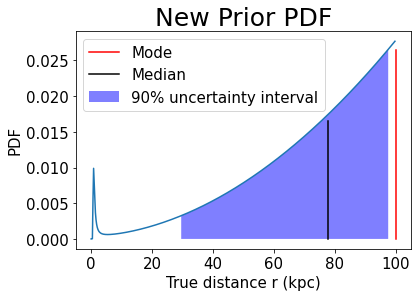

In [28]:
#Numerical results
print("---------------------------------------------------------------------------")
print("                             Bayesian methods                              ")
print("---------------------------------------------------------------------------")
print("\t| Mode (pc) \t Median (pc) \t r_inf (pc) \tr_sup (pc)")
print("---------------------------------------------------------------------------")
print("UD PDF \t|","{0:.2f}".format(r_mode*1000),"\t","{0:.2f}".format(r_media*1000),"\t","{0:.2f}".format(r_inf*1000),"\t","{0:.2f}".format(r_sup*1000))
print("---------------------------------------------------------------------------")
    
    
# Probability Distribution Function for the Bayesin Methods
x = np.arange(r0,r_lim,r_lim/500)
y1 = [posterior(i,w,s,r_lim)/n for i in x]
    
x_mode = np.ones(20)*r_mode
dim_mode = posterior(r_mode,w,s,r_lim)/n
y_mode = np.arange(0,dim_mode,dim_mode/20)
    
x_median = np.ones(20)*r_media
dim_media = posterior(r_media,w,s,r_lim)/n
y_media = np.arange(0,dim_media,dim_media/20)
    
x_uncertainty = np.arange(r_inf,r_sup,1)
y_uncertainty = [posterior(k,w,s,r_lim)/n for k in x_uncertainty]
    
    
plt.figure()
plt.rc('axes', titlesize=25)     
plt.rc('axes', labelsize=15)
plt.rc('font',size = 15)
    
plt.plot(x, y1)
plt.plot(x_mode,y_mode,label = 'Mode',color = "red")
plt.plot(x_median,y_media,label = 'Median', color = "black")
plt.fill_between(x_uncertainty,0,y_uncertainty,facecolor = 'blue',alpha=0.5,label='90% uncertainty interval')
plt.title('New Prior PDF')
plt.xlabel('True distance r (kpc)')
plt.ylabel('PDF')
plt.legend()
plt.show()     


All the priors used in this tutorial only make an _a priori_ assumption about the spatial distribution of the stars in the Milky Way. For instance, the _Uniform Density Prior_ assumes that the probability density of finding a star around us is the same for every distance until a limit distance $r_{lim}$, where it goes to 0, and the _Exponentially Decreasing Space Density Prior_ assumes that it is more probable to find a star closer than further away. However, if we dispose of further information of the sample, such as its latitude and longitude, its observed magnitude or which kind of object it is we can construct more complex priors that will provide distances and distance modulus closer to the true ones.

## 5. Exercise

Using true distances and the simulated parallaxes from tutorial 1 generate distance estimations with the different methods (including the inverse of the parallax) and compare the results with the real distances from the simulation. Plot the comparisons and draw conclusions from them.

Alternatively, if you want to run this tutorial independently, you can generate a test file containing "true" distances and observed parallaxes from the GUMS and GOG simulations contained in the Gaia archive using the following query:

    select U.source_id, U.barycentric_distance, S.parallax, S.parallax_error
    from gaiaedr3.gaia_universe_model as U
    JOIN gaiaedr3.gaia_source_simulation as S
    using (source_id)
    WHERE U.ra>1 and U.ra<4 and U.dec>0.1 and U.dec<0.3
    
The result of this query is stored as _GUMS-GOG.csv_ (1317 objects)

## 6. Conclusions

To sum up, we have shown how to use the module _pyrallaxes.py_ in order to compute distances and distance modulus without having to invert the parallax. We have also highlighted the importance of providing an uncertainty interval associated to every estimate.

We have used two Bayesian Methods with simple, uninformative priors, and the frequentist Transformation Method. We have also shown that it is easy to define new priors and use the functions defined in _pyrallaxes.py_ in order to compute the median and the uncertainty interval. Moreover, you can also use more elaborated priors taking profit of the extra information you have of the object, as it is explained in [Luri et al. (2018)](https://arxiv.org/abs/1804.09376). 

You can also find an extended explanation of the methods used in [Luri et al. (2018)](https://arxiv.org/abs/1804.09376).

## 7. References

[1] Coryn A. L. Bailer-Jones. Estimating distances from parallaxes._ The Astronomical Society of the Paciﬁc_, 127:994–1009, 2015.

[2] Haywood Smith, Jr. Transformation methods for trigonometric parallaxes. _Kluwer Academic publishers_, pages 1–12, 200.

[3] Jr Haywood Smith and Heinrich Eichhorn. On the estimation of distances from trigonometric parallaxes. _Royal Astronomical Society_, 281:211–218, 1996